In [1]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [113]:
def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x
    pairs['temp'] = timeline(period)
    
    X = pairs[['x', 'temp']]
    X = sm.add_constant(X)
    model = sm.OLS(pairs['y'], X).fit()
    return model

#O desvio padrão de uma estimativa é chamado de erro padrão
def stderr(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.bse['temp'],
            "angular":model.bse['x'],
            "intercept":model.bse['const']}
    
def residue(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def returns(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def correlation(y, x, period):
    y_log, x_log = returns(y, x, period)
    return y_log.corr(x_log)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def invert(y, x, period):
    coef_main = coefficients(y, x, period)
    coef_invert = coefficients(x, y, period)
    if (abs(coef_main['temp'])<=abs(coef_invert['temp'])):
        return False
    return True

def ratio_diff(y, x, period):
    coef = coefficients(y, x, period)
    res = residue(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    return y-x
    
def intercept_coef(y, x, period):
    coef = coefficients(y, x, period)
    res = residue(y, x, period)
    diff = ratio_diff(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = ratio_diff(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_uhlenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = residue(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def halflife_ser(y, x, period):
    return ornstein_uhlenbeck(y, x, period)['halffile']

def halflile(series):
    lag = np.roll(series, 1)
    lag[0] = 0
    ret = series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)
    res = sm.OLS(ret, lag2).fit()
    half_life = int(round(-np.log(2) / res.params[1],0))

    if half_life <= 0:
        half_life = 1
    return half_life
    
def statisticspair(y, x, desv_input, period):
    res = residue(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": desv_input*std,
        "std_down": -desv_input*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }

def trade_stop(y, x, period):
    res = residue(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = res.mean()-3.1*res.std()
    std_up = res.mean()+3.1*res.std()
    
    est = coefficients(y, x, period)
    l_res = res[0]
    price = x[0]
    
    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def trade_output(y, x, period):
    price = x[0]
    est = coefficients(y, x, period)
    value1 = (est['angular']*price+est['intercept']+est['temp']*period)/price
    value2 = 1/((est['angular']*price+est['intercept']+est['temp']*period)/price)
    return max(value1, value2)

def trade_input(y, x, period):
    price = x[0]
    res = residue(y, x, period)
    l_res = res[0]
    est = coefficients(y, x, period)
    std_up = 2*res.std()
    std_down = -2*res.std()

    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def ratio_current(y, x):
    ratio = y[0]/x[0]
    return {
        "ratio": ratio,
        "value": 1/ratio
    }

def loss_percent(y, x, period):
    return -abs(trade_stop(y, x, period)/trade_input(y, x, period)-1)

def current_percent(y, x, period):
    ratio = ratio_current(y, x)
    return abs(trade_output(y, x, period)/max(ratio['ratio'], ratio['value'])-1)

def return_percent(y, x, period):
    return abs(trade_output(y, x, period)/trade_input(y, x, period)-1)

def loss(y, x, lot, period):
    return y[0]*lot*loss_percent(y, x, period)

def gain(y, x, lot, period):
    return current_percent(y, x, period)*lot*y[0]
    
def sinal(value):
    if(value < 0):
        return -1
    return 1

def dickey_fuller(series):
    model = ts.adfuller(series, 1)
    p_value = model[1]
    statistic = model[0]

    # Dickey-Fuller
    is_stationary = False
    if (p_value < .05):
        is_stationary = True

    # Augmented Dickey Fuller (ADF)
    perc_stat = 0
    if (abs(statistic) > abs(model[4]['1%'])):
        perc_stat = 99
    elif (abs(statistic) > abs(model[4]['5%'])):
        perc_stat = 95
    elif (abs(statistic) > abs(model[4]['10%'])):
        perc_stat = 90
        
    return {
        "is_stationary": is_stationary,
        "p_value": p_value,
        "adf": perc_stat,
        "statistic": statistic
    }

#função DESVQ do excel
def desvq(values):
    return np.power(values-values.mean(), 2).sum()

#função EPADYX do excel
def epadyx(y, x):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    X = sm.add_constant(res)
    fit = sm.OLS(rdiff, X).fit()
    return np.sqrt(fit.mse_resid)
    
def adf_ser(y, x, period):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    res[0]=0
    rdiff[0]=0

    inter_cof = intercept_coef(y, x, period)
    return inter_cof/(epadyx(rdiff, res)/np.sqrt(desvq(res)))

def rejeitado_h0(adf):
    if adf<=0:
        if adf<=-4.32: return 99
        if adf<=-3.67: return 95
        if adf<=-3.28: return 90
    else:
        if adf<=-3.58: return 99
        if adf<=-3.22: return 95
        if adf<=-2.6: return 90
    return 0

def dickey_fuller_ger(y, x, period):
    adf_statistic = adf_ser(y, x, period)
    rej = rejeitado_h0(adf_statistic)
    return {
        "statistic": adf_statistic,
        "adf": rej
    }

"""def acerta_t0(y, x, period):
    reg = regression(y, x, period)
    coef_temp = reg.params['temp']
    err_temp = reg.bse['temp']
    v_t = (coef_temp/err_temp)
    return (abs(v_t)<AW5;99%;0)"""

def signal(y, x, desv_input, period):
    y, x, get_values(y, x, period)
    resid = residue(y, x, period)[::-1]
    
    std = resid.std()
    resid_current = resid.iloc[-1]
    zscore_up = desv_input*std
    zscore_down = -desv_input*std
    zcurrent = 0
    descr = ''
    
    # >0; resíduo acima da linha 0
    if(resid_current > resid.mean()):
        descr = 'Short/Long'
        zcurrent = zscore_up
    else:
        descr = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resid_current)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return {
        "descr": descr, 
        "resid_current": resid_current, 
        "percent_dist_mean": percent}

def find(data):
    rows = []
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
                
            for period in [250, 240, 220, 200, 180, 160, 140, 120, 100]:
                y, x = get_values(data[y_symbol], data[x_symbol], period)
                dickey = dickey_fuller(residue(y, x, period))
                
                # find only an is stationary, then break looping
                if (dickey['is_stationary']):
                    coeff = coefficients(y, x, period)
                    rows.append([period, y_symbol, x_symbol, dickey['p_value'], dickey['adf'], coeff['angular']])
                    break
            
            # for only testing
            if (len(rows) >= 1):
                break
    return rows

def find_pairs(data):
    df_pairs = pd.DataFrame(find(data), columns=['Period', 'Dependent', 'Independent', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        half = halflile(residue(y, x, period))
        pairs['HalfLife'].iloc[i]=half

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)

        corr = correlation(y, x, period)
        pairs['Corr'].iloc[i] = corr
        
def apply_signal(data, pairs, desv_input):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        sig = signal(y, x, desv_input, period)
        pairs['Signal'].iloc[i] = sig['descr']
        pairs['SignalStr'].iloc[i] = sig['percent_dist_mean']
        
"""def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependent']]
        x = data[row['Independent']]
        
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des"""

def check_periods(y, x):
    periods=[]
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        dickey = dickey_fuller(residue(y, x, period))
        if (dickey['is_stationary']):
            periods.append(period)
    return periods
        
def analysis_periods(y, x):
    rows=[]
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        y_values, x_values = get_values(y, x, period)

        res_dic = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)

        rows.append([period, res_dic['is_stationary'], res_dic['p_value'], res_dic['perc_stat'], res_dic['beta'], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

In [114]:
check_periods(y, x)

[100, 220, 240, 250]

In [115]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]

In [103]:
#ABEV3 AZUL4
y_symbol = 'ABEV3'
x_symbol = 'AZUL4'
period = 250

In [97]:
pairs = find_pairs(data)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [98]:
apply_halflife(data, pairs)
pairs.tail(5)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife
49,220,TIMP3,TOTS3,0.034964,95,0.081044,9
50,250,UGPA3,USIM5,0.002057,99,2.320393,6
51,100,USIM5,VALE3,0.022404,95,0.308060,4
52,100,VALE3,VIVT4,0.020266,95,1.331572,5
53,240,VIVT4,VVAR3,0.043523,95,0.699206,11


In [99]:
apply_corr(data, pairs)
pairs.tail(5)

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr
49,220,TIMP3,TOTS3,0.034964,95,0.081044,9,0.127853
50,250,UGPA3,USIM5,0.002057,99,2.320393,6,0.665529
51,100,USIM5,VALE3,0.022404,95,0.308060,4,0.704014
52,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147
53,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329


In [108]:
apply_signal(data, pairs, 2)
pairs.tail(5)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr
49,220,TIMP3,TOTS3,0.034964,95,0.081044,9,0.127853,Short/Long,0.279039
50,250,UGPA3,USIM5,0.002057,99,2.320393,6,0.665529,Long/Short,0.758864
51,100,USIM5,VALE3,0.022404,95,0.308060,4,0.704014,Short/Long,0.864725
52,100,VALE3,VIVT4,0.020266,95,1.331572,5,0.494147,Long/Short,0.097942
53,240,VIVT4,VVAR3,0.043523,95,0.699206,11,0.437329,Long/Short,0.825008


In [100]:
y, x = get_values(data[y_symbol], data[x_symbol], period)

In [101]:
print('{}:  {} {}:  {}'.format(y_symbol, y[0], x_symbol, x[0]))
print('halflife_ser: {}'.format(halflife_ser(y, x, period)))
print('correlation: {}'.format(correlation(y, x, period)))
print('trade_stop: {}'.format(trade_stop(y, x, period)))
print('trade_output: {}'.format(trade_output(y, x, period)))
print('trade_input: {}'.format(trade_input(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('return_percent: {}'.format(return_percent(y, x, period)*100))
print('loss: {}'.format(loss(y, x, 1000, period)))
print('gain: {}'.format(gain(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))
print('invert: {}'.format(invert(y, x, period)))

ABEV3:  14.17 AZUL4:  20.76
halflife_ser: 31.929095676391768
correlation: 0.6159098685920903
trade_stop: 1.3940216928735825
trade_output: 1.693247575871775
trade_input: 1.4872834128061356
loss_percent: -6.2706084885725595
current_percent: 15.574750241344182
return_percent: 13.848346676376643
loss: -888.5452228307317
gain: 2206.9421091984705
intercept_coef: -0.06071731166204694
intercept_inter: 0.04717711999780044
invert: False


In [23]:
halflile(residue(y, x, period))

9

In [24]:
dickey_fuller(residue(y, x, period))

{'is_stationary': True,
 'p_value': 0.01810938124483713,
 'adf': 95,
 'statistic': -3.233805859381667}

In [26]:
dickey_fuller_ger(y, x, period)

{'statistic': -2.5873878574986735, 'adf': 0}

In [12]:
statisticspair(y, x, 2 ,period)

{'std': 0.8489357406980574,
 'std_up': 1.6978714813961149,
 'std_down': -1.6978714813961149,
 'mean': -8.895995051716454e-15,
 'min': -3.567992992426161,
 'max': 3.7933288849846747}

In [13]:
ornstein_uhlenbeck(y, x, period)

{'halffile': 31.929095676391768,
 'beta': 0.06263879253801702,
 'alpha': 1.2870075931908898,
 'sigma': 0.6191839341325651}

In [14]:
coefficients(y, x, period)

{'temp': -0.01461470730139998,
 'angular': 0.11706168413735096,
 'intercept': 13.483939703340992}

In [15]:
reg = regression(y, x, period)
reg

In [105]:
stderr(y, x, period)

{'temp': 0.0010594271664292314,
 'angular': 0.004541639341634845,
 'intercept': 0.3022221744016457}

In [106]:
signal(y, x, 2, period)

{'descr': 'Short/Long',
 'resid_current': 1.9095365593175977,
 'percent_dist_mean': 1.1246649585912334}

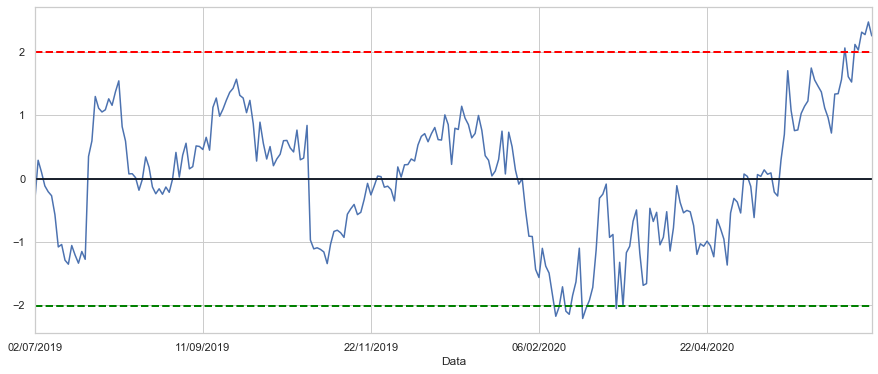

In [18]:
res = residue(data[y_symbol], data[x_symbol], period)
# antes de plotar os dados devem ser invertidos para ordem crescente
ret = zscore(res[::-1])
std = ret.std()
ret.plot(figsize=(15,6))
plt.axhline(ret.mean())

plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(2*std, color='red', linestyle='--', linewidth=2)
plt.axhline(-2*std, color='green', linestyle='--', linewidth=2)

In [19]:
#reg.resid[::-1].plot(figsize=(15,6))

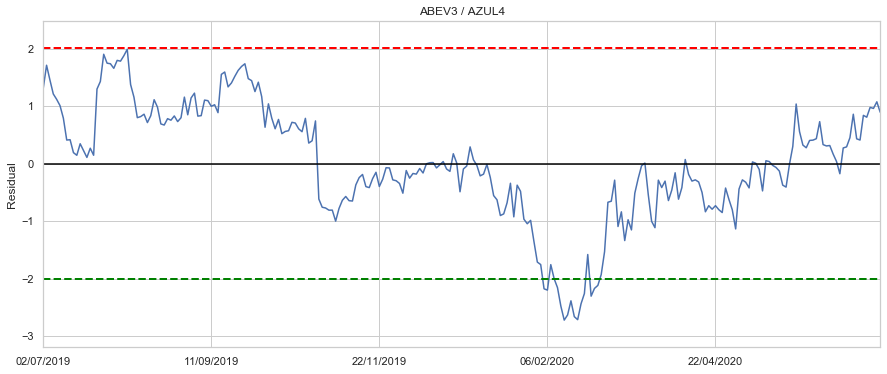

In [20]:
show(data[::-1], y_symbol, x_symbol, period)

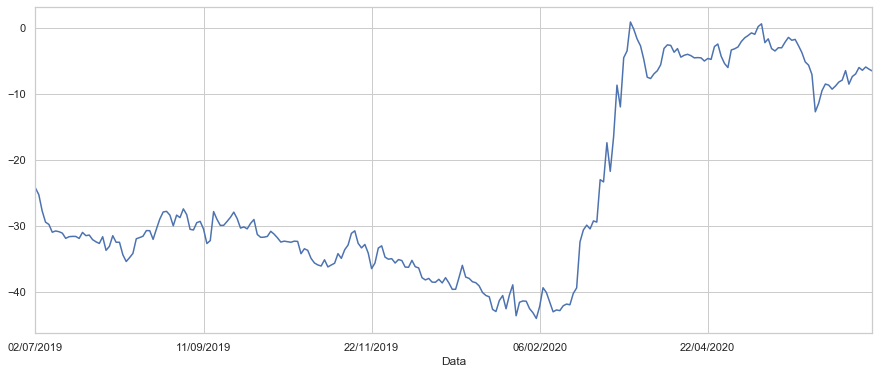

In [21]:
ratio_continuo(y, x, period)[::-1].plot(figsize=(15,6))